In [1]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

model_dir = './models/'
model_file = model_dir + 'vg16_trf_learning.keras'

Keras = 2.15.0
Num GPUs Available:  1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! unzip -o drive/MyDrive/dataset_19.zip

! pwd

Archive:  drive/MyDrive/dataset_19.zip
   creating: dataset_19/glioma/
  inflating: dataset_19/glioma/Te-gl_0010.jpg  
  inflating: dataset_19/glioma/Te-gl_0016.jpg  
  inflating: dataset_19/glioma/Te-gl_0020.jpg  
  inflating: dataset_19/glioma/Te-gl_0026.jpg  
  inflating: dataset_19/glioma/Te-gl_0035.jpg  
  inflating: dataset_19/glioma/Te-gl_0041.jpg  
  inflating: dataset_19/glioma/Te-gl_0043.jpg  
  inflating: dataset_19/glioma/Te-gl_0044.jpg  
  inflating: dataset_19/glioma/Te-gl_0045.jpg  
  inflating: dataset_19/glioma/Te-gl_0057.jpg  
  inflating: dataset_19/glioma/Te-gl_0060.jpg  
  inflating: dataset_19/glioma/Te-gl_0075.jpg  
  inflating: dataset_19/glioma/Te-gl_0079.jpg  
  inflating: dataset_19/glioma/Te-gl_0085.jpg  
  inflating: dataset_19/glioma/Te-gl_0090.jpg  
  inflating: dataset_19/glioma/Te-gl_0107.jpg  
  inflating: dataset_19/glioma/Te-gl_0114.jpg  
  inflating: dataset_19/glioma/Te-gl_0125.jpg  
  inflating: dataset_19/glioma/Te-gl_0126.jpg  
  inflating: data

# Load the data

In [4]:
# Data Directories
dir = "dataset_19/"


## Data Distribution

In [ ]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

pituitary     120
notumor       120
meningioma    120
glioma        120
dtype: int64

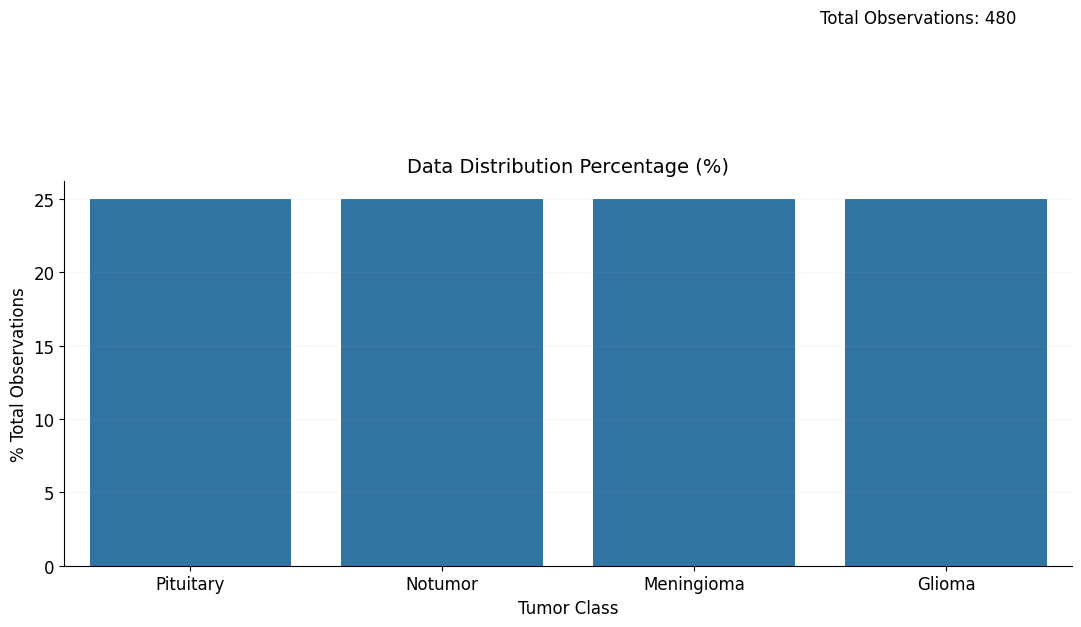

In [ ]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

## Splitting the data

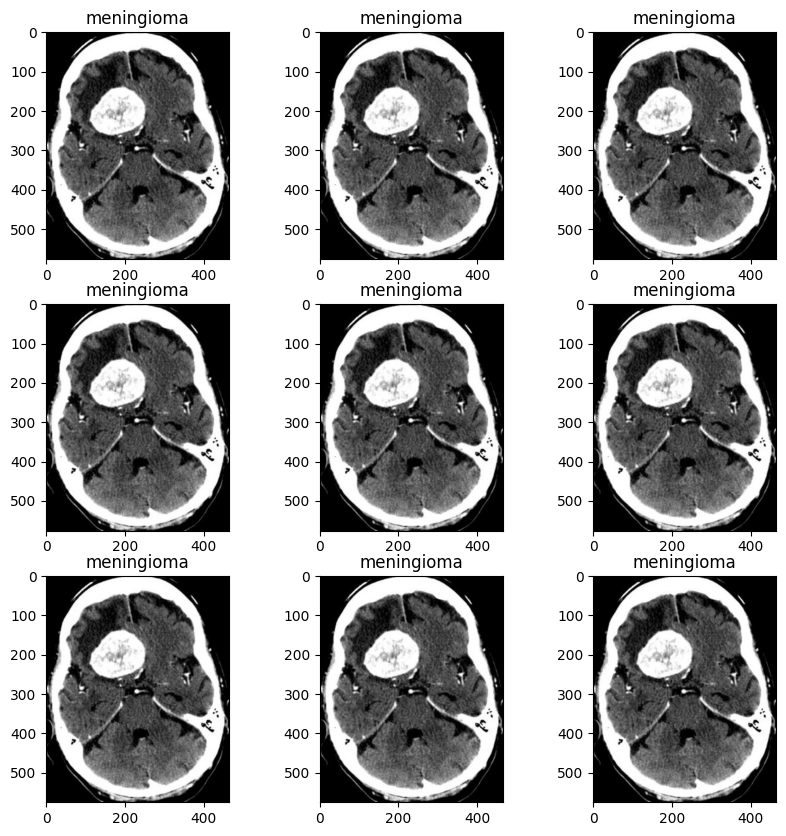

In [5]:
from tqdm import tqdm
import cv2
import imutils

def crop_img(img):

	# Find extreme points on the image and crop the rectangular out

	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

	return new_img

def preprocess_images(directory):
    for dir in os.listdir(directory):
        path = os.path.join(directory, dir)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            cropped_img = crop_img(img)
            cv2.imwrite(img_path, cropped_img)

# Preprocess the images before generating data
preprocess_images(dir)

# Display 9 image using matplotlib
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for curr_index in os.listdir(dir):
        path = os.path.join(dir, curr_index)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            image = plt.imread(img_path)
            plt.imshow(image)
            plt.title(curr_index)
            break
        break

In [6]:
classes = os.listdir(dir)

batch_size = 10

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    subset='training'
)

test_generator = validation_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    subset='validation')


print(test_generator.class_indices)

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# Training a VGG16 model

In [ ]:
# !pip install optuna optuna-integration

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.5 MB/s eta 0:00:00


In [11]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.0 MB/s eta 0:00:00


In [ ]:
# import optuna
# from keras.applications import VGG16
# from keras.models import Model
# from keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
# from keras.regularizers import l2
# from tensorflow_addons.optimizers import RectifiedAdam
# import tensorflow as tf
# from keras.callbacks import *


# def VGG16_trf_learning(input_shape, num_classes, l2_reg_1):
#     base_model = VGG16(weights='imagenet', include_top=False,input_shape=(224,224,3))

#     # Exclude the bottom three layers (remove last 3 layers)
#     base_model_layers = base_model.layers[:-3]

#     # Create a new model with the remaining layers
#     x = base_model_layers[-1].output
#     x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.055)(x)

#     output = Dense(num_classes, activation='softmax', dtype='float64', kernel_regularizer=l2(l2_reg_1))(x)

#     model = Model(inputs=base_model.input, outputs=output)

#     learning_rate = 0.0001
#     radam = RectifiedAdam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
#     model.compile(optimizer=radam,
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy', 'categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

#     return model

# def objective(trial):
#     # dropout_rate_1 = trial.suggest_float('dropout_rate_1', 0.0, 0.5)
#     # dropout_rate_2 = trial.suggest_float('dropout_rate_2', 0.0, 0.5)
#     l2_reg_1 = trial.suggest_float('l2_reg_1', 0.0, 0.2)

#     model = VGG16_trf_learning(input_shape, num_classes, l2_reg_1)

#     # Define callbacks
#     # checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
#     early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
#     reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

#     # Train the model
#     history = model.fit(
#         train_generator,
#         steps_per_epoch=train_generator.samples // train_generator.batch_size,
#         epochs=80,
#         validation_data=test_generator,
#         validation_steps=test_generator.samples // test_generator.batch_size,
#         callbacks=[early_stopping, reduce_lr],
#         verbose=1
#     )

#     val_loss = min(history.history['val_loss'])
#     return val_loss

# # Define input shape and number of classes
# input_shape = (224, 224, 3)
# num_classes = 4


# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=35)

# print('Best trial:')
# trial = study.best_trial
# print(f'  Value: {trial.value}')
# print('  Params:')
# for key, value in trial.params.items():
#     print(f'    {key}: {value}')


[I 2024-06-06 03:11:38,923] A new study created in memory with name: no-name-01017011-f1cc-43d8-a74c-00efcb998763


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 2.3042 - accuracy: 0.2995 - categorical_accuracy: 0.2995 - precision_21: 0.2973 - recall_21: 0.2005

Exception ignored in: <function _xla_gc_callback at 0x7f5ad604cee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


24/24 [==============================] - 99s 4s/step - loss: 2.3042 - accuracy: 0.2995 - categorical_accuracy: 0.2995 - precision_21: 0.2973 - recall_21: 0.2005 - val_loss: 1.7626 - val_accuracy: 0.3438 - val_categorical_accuracy: 0.3438 - val_precision_21: 0.0000e+00 - val_recall_21: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/80
24/24 [==============================] - 6s 245ms/step - loss: 2.2632 - accuracy: 0.2318 - categorical_accuracy: 0.2318 - precision_21: 0.2099 - recall_21: 0.1328 - val_loss: 1.7496 - val_accuracy: 0.3438 - val_categorical_accuracy: 0.3438 - val_precision_21: 0.0000e+00 - val_recall_21: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/80
24/24 [==============================] - 7s 308ms/step - loss: 2.1369 - accuracy: 0.2760 - categorical_accuracy: 0.2760 - precision_21: 0.2874 - recall_21: 0.1849 - val_loss: 1.7360 - val_accuracy: 0.3333 - val_categorical_accuracy: 0.3333 - val_precision_21: 0.0000e+00 - val_recall_21: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/80
24/24 [==============

[I 2024-06-06 03:18:25,299] Trial 0 finished with value: 1.4393612146377563 and parameters: {'l2_reg_1': 0.04808421386795534}. Best is trial 0 with value: 1.4393612146377563.


Epoch 1/80
24/24 [==============================] - 8s 250ms/step - loss: 2.0226 - accuracy: 0.2760 - categorical_accuracy: 0.2760 - precision_22: 0.2704 - recall_22: 0.1641 - val_loss: 1.6316 - val_accuracy: 0.2500 - val_categorical_accuracy: 0.2500 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/80
24/24 [==============================] - 7s 272ms/step - loss: 2.0708 - accuracy: 0.2188 - categorical_accuracy: 0.2188 - precision_22: 0.2150 - recall_22: 0.1198 - val_loss: 1.6005 - val_accuracy: 0.2396 - val_categorical_accuracy: 0.2396 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/80
24/24 [==============================] - 5s 225ms/step - loss: 1.9502 - accuracy: 0.2604 - categorical_accuracy: 0.2604 - precision_22: 0.2732 - recall_22: 0.1380 - val_loss: 1.5785 - val_accuracy: 0.2604 - val_categorical_accuracy: 0.2604 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/80
24/24 [=

[I 2024-06-06 03:23:52,038] Trial 1 finished with value: 1.1873518228530884 and parameters: {'l2_reg_1': 0.024198501110124983}. Best is trial 1 with value: 1.1873518228530884.


Epoch 1/80
24/24 [==============================] - 9s 326ms/step - loss: 3.1310 - accuracy: 0.2604 - categorical_accuracy: 0.2604 - precision_23: 0.2652 - recall_23: 0.1589 - val_loss: 2.6851 - val_accuracy: 0.2500 - val_categorical_accuracy: 0.2500 - val_precision_23: 0.0000e+00 - val_recall_23: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/80
24/24 [==============================] - 8s 350ms/step - loss: 3.1356 - accuracy: 0.2422 - categorical_accuracy: 0.2422 - precision_23: 0.2629 - recall_23: 0.1719 - val_loss: 2.6618 - val_accuracy: 0.2500 - val_categorical_accuracy: 0.2500 - val_precision_23: 0.0000e+00 - val_recall_23: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/80
24/24 [==============================] - 6s 234ms/step - loss: 3.1128 - accuracy: 0.2396 - categorical_accuracy: 0.2396 - precision_23: 0.2336 - recall_23: 0.1484 - val_loss: 2.6427 - val_accuracy: 0.2500 - val_categorical_accuracy: 0.2500 - val_precision_23: 0.0000e+00 - val_recall_23: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/80
24/24 [=

[I 2024-06-06 03:34:27,881] Trial 2 finished with value: 1.4474010467529297 and parameters: {'l2_reg_1': 0.15719145524424483}. Best is trial 1 with value: 1.1873518228530884.


Epoch 1/80
24/24 [==============================] - 9s 320ms/step - loss: 2.1369 - accuracy: 0.2318 - categorical_accuracy: 0.2318 - precision_24: 0.2143 - recall_24: 0.1328 - val_loss: 1.5755 - val_accuracy: 0.2500 - val_categorical_accuracy: 0.2500 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/80
24/24 [==============================] - 5s 222ms/step - loss: 2.0716 - accuracy: 0.2448 - categorical_accuracy: 0.2448 - precision_24: 0.2544 - recall_24: 0.1510 - val_loss: 1.5632 - val_accuracy: 0.2292 - val_categorical_accuracy: 0.2292 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/80
24/24 [==============================] - 6s 255ms/step - loss: 2.1075 - accuracy: 0.2422 - categorical_accuracy: 0.2422 - precision_24: 0.2455 - recall_24: 0.1406 - val_loss: 1.5517 - val_accuracy: 0.2188 - val_categorical_accuracy: 0.2188 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/80
24/24 [=

[W 2024-06-06 03:36:29,534] Trial 3 failed with parameters: {'l2_reg_1': 0.021297804084090034} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-20-781cd44bd80e>", line 48, in objective
    history = model.fit(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 832, in __call__
    result = self._

KeyboardInterrupt: 

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

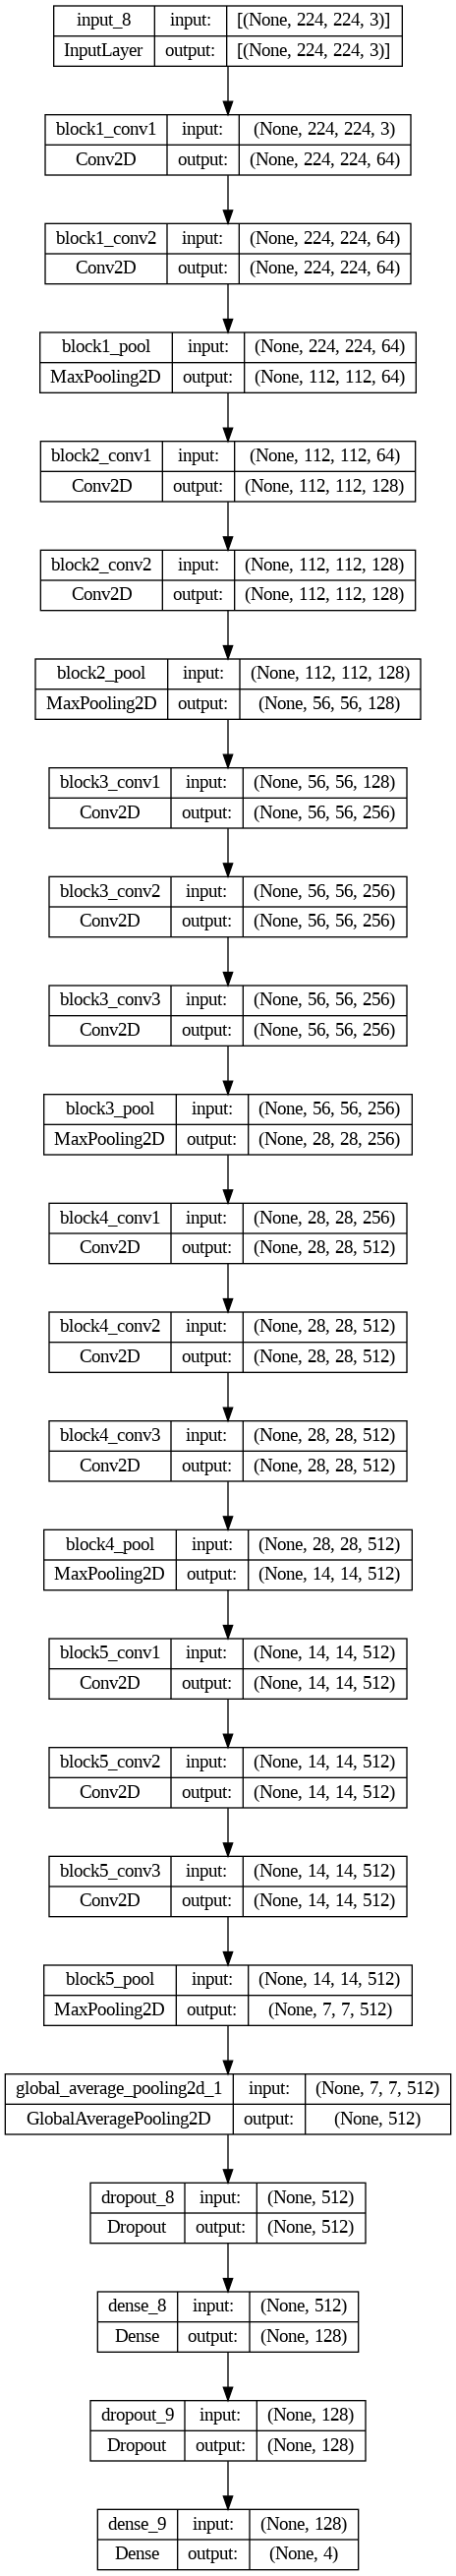

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras.regularizers import l2

def VGG16_trf_learning(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    base_model.layers[-3].trainable = True
    base_model.layers[-2].trainable = True
    base_model.layers[-1].trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.05)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.05)(x)

    output = Dense(num_classes, activation='softmax', dtype='float64', kernel_regularizer=l2(0.1))(x)

    model = Model(inputs=base_model.input, outputs=output)

    learning_rate = 0.0001
    radam = RectifiedAdam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=radam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 4

# Create the model
model = VGG16_trf_learning(input_shape, num_classes)

# Display the model summary
model.summary()

# You can plot the model to visualize the architecture
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [ ]:
from keras.callbacks import *

# Define callbacks
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 4.2283 - accuracy: 0.2727 - categorical_accuracy: 0.2727 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00
Epoch 1: val_loss improved from inf to 4.06437, saving model to ./models/vg16_trf_learning.keras
38/38 [==============================] - 8s 170ms/step - loss: 4.2283 - accuracy: 0.2727 - categorical_accuracy: 0.2727 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 4.0644 - val_accuracy: 0.5333 - val_categorical_accuracy: 0.5333 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 4.0200 - accuracy: 0.4332 - categorical_accuracy: 0.4332 - precision_4: 1.0000 - recall_4: 0.0027
Epoch 2: val_loss improved from 4.06437 to 3.90201, saving model to ./models/vg16_trf_learning.keras
38/38 [==============================] - 8s 212ms/step - loss: 4.0200 - accuracy: 0.4332 - categorical_accuracy: 0.4332 - precision_4: 1.000

# Testing the Model

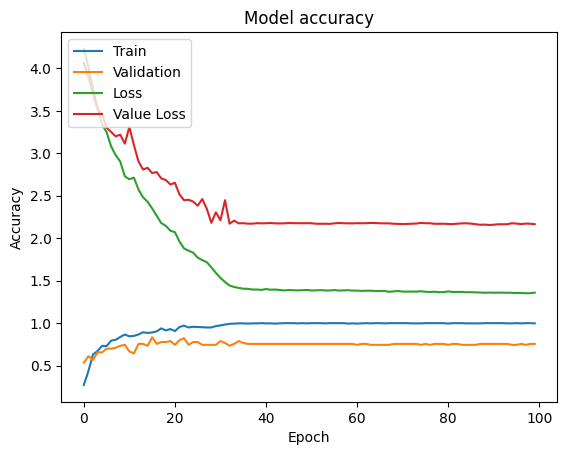

In [ ]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Loss', 'Value Loss'], loc='upper left')
plt.show()

In [15]:
# Validate the model with test data

model = keras.models.load_model(model_file)
model.evaluate(test_generator)


# Predict and Display image using matplotlib
# plt.figure(figsize=(20, 20))
# for i in range(9):
#     plt.subplot(3, 3, i + 1)
#     for X_batch, Y_batch in test_generator:
#         image = X_batch[0]
#         # Print Class
#         plt.title("Predicted: " + classes[predictions[i]] + "\nActual: " + classes[np.argmax(Y_batch[i])])

#         plt.imshow(image)
#         break


10/10 [==============================] - 1s 55ms/step - loss: 1.9204 - accuracy: 0.8542 - categorical_accuracy: 0.8542 - precision_5: 0.8913 - recall_5: 0.8542


[1.9204177856445312,
 0.8541666865348816,
 0.8541666865348816,
 0.8913043737411499,
 0.8541666865348816]

# Model Visualisation (Evaluation)

10/10 [==============================] - 1s 63ms/step


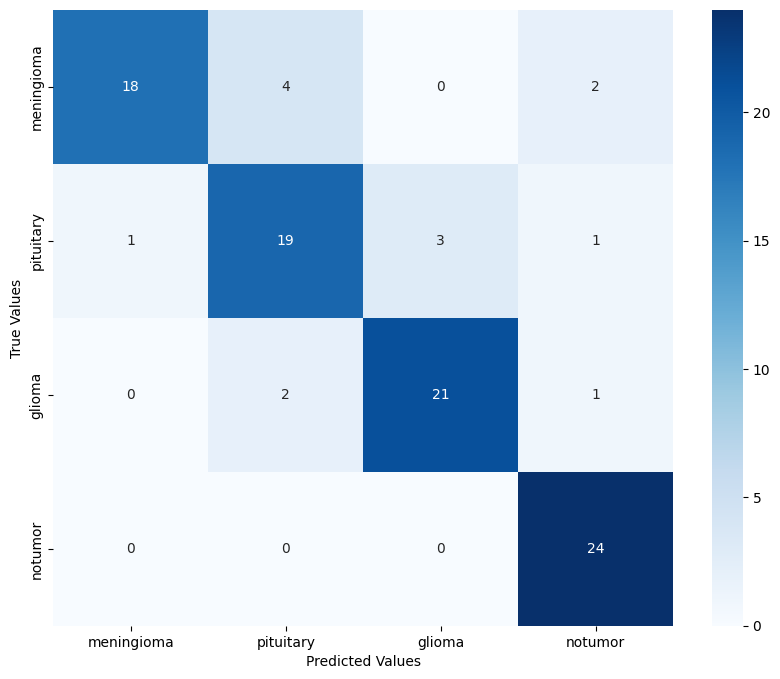

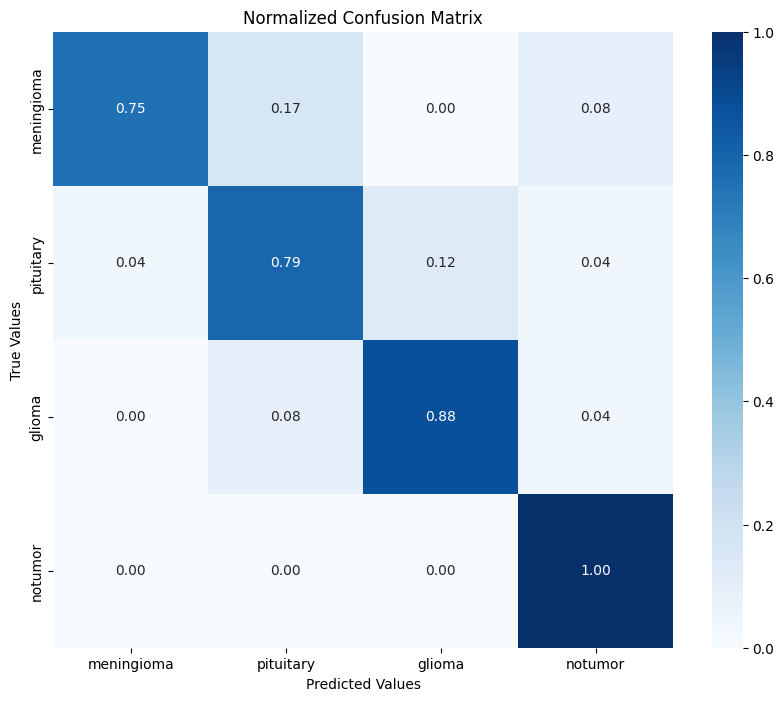

DSC: 0.8526991073710344, Sensitivity: 0.8541666666666666, Specificity: 0.9513888888888888, Accuracy: 0.8541666666666666


In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Assuming 'classes' contains the class labels
classes = ['meningioma', 'pituitary', 'glioma', 'notumor']

def calculate_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.show()

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Calculate metrics for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return dsc, sensitivity, specificity, accuracy

# Assuming 'model' is your trained model and 'test_generator' is your test data generator
predictions_prob = model.predict(test_generator)
predictions = np.argmax(predictions_prob, axis=1)

# Assuming 'test_generator.classes' contains the true labels
y_true = test_generator.classes
y_pred = predictions

dsc, sensitivity, specificity, accuracy = calculate_metrics(y_true, y_pred)
print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")

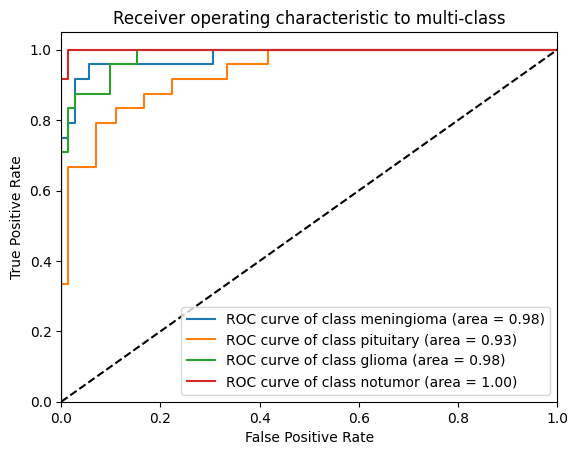

              precision    recall  f1-score   support

  meningioma       0.95      0.75      0.84        24
   pituitary       0.76      0.79      0.78        24
      glioma       0.88      0.88      0.88        24
     notumor       0.86      1.00      0.92        24

   micro avg       0.85      0.85      0.85        96
   macro avg       0.86      0.85      0.85        96
weighted avg       0.86      0.85      0.85        96
 samples avg       0.85      0.85      0.85        96



In [17]:
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output
lb = LabelBinarizer()
y_test = lb.fit_transform(test_generator.classes)
y_pred = lb.transform(predictions)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i, class_name in enumerate(classes):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=classes))

# KFolds

In [25]:
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set parameters
input_shape = (224, 224, 3)
num_classes = 4
batch_size = 16
epochs = 10
data_dir = 'dataset_19'

# Function to create the model
def VGG16_trf_learning(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    base_model.layers[-3].trainable = True
    base_model.layers[-2].trainable = True
    base_model.layers[-1].trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.05)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.05)(x)

    output = Dense(num_classes, activation='softmax', dtype='float64', kernel_regularizer=l2(0.1))(x)

    model = Model(inputs=base_model.input, outputs=output)

    learning_rate = 0.0001
    radam = RectifiedAdam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=radam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

# Data augmentation configuration
datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    validation_split=0.2
)

# Load all data to split it manually
data_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Prepare dataset
X = np.zeros((data_generator.samples, 224, 224, 3))
y = np.zeros((data_generator.samples, len(data_generator.class_indices)))

for i in range(data_generator.samples):
    X[i], y[i] = data_generator.next()

# K-Fold Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=42)
fold_no = 1
val_scores = []

for train_index, val_index in kfold.split(X, y):
    print(f'Training fold {fold_no}...')

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        horizontal_flip=True,
        rotation_range=20,
        width_shift_range=0.05,
        height_shift_range=0.05
    )

    train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
    val_data = (X_val, y_val)

    model = VGG16_trf_learning(input_shape, num_classes)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

    history = model.fit(
        train_generator,
        steps_per_epoch=len(X_train) // batch_size,
        epochs=epochs,
        validation_data=val_data,
        callbacks=[early_stopping, reduce_lr]
    )

    loss, accuracy, _, _, _ = model.evaluate(X_val, y_val, batch_size=batch_size)
    val_scores.append(accuracy)

    print(f'Validation accuracy for fold {fold_no}: {accuracy}')

    fold_no += 1

average_val_accuracy = np.mean(val_scores)
print(f'Average validation accuracy across all folds: {average_val_accuracy}')


Found 480 images belonging to 4 classes.
Training fold 1...
Epoch 1/10
22/22 [==============================] - 18s 789ms/step - loss: 4.2916 - accuracy: 0.2413 - categorical_accuracy: 0.2413 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 4.3817 - val_accuracy: 0.1917 - val_categorical_accuracy: 0.1917 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/10
22/22 [==============================] - 5s 229ms/step - loss: 4.2277 - accuracy: 0.2529 - categorical_accuracy: 0.2529 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 4.3257 - val_accuracy: 0.1250 - val_categorical_accuracy: 0.1250 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/10
22/22 [==============================] - 4s 199ms/step - loss: 4.2016 - accuracy: 0.2616 - categorical_accuracy: 0.2616 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_loss: 4.2818 - val_accuracy: 0.1167 - val_categorical_accuracy: 0.1167 - val_precision_7: 0